# Holidays and Special Dates

Calendar variables and special dates are one of the most common types of exogenous variables used in forecasting applications. They provide additional context on the current state of the time series, especially for window-based models such as TimeGPT-1. These variables often include adding information on each observation's month, week, day, or hour. For example, in high-frequency hourly data, providing the current month of the year provides more context than the limited history available in the input window to improve the forecasts.

In this tutorial we will show how to add calendar variables automatically to a dataset using the `date_features` function.

In [ ]:
#| hide
from nixtla.utils import colab_badge

In [ ]:
#| echo: false
colab_badge('docs/tutorials/2_holidays')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/2_holidays.ipynb)

In [ ]:
#| hide
from fastcore.test import test_eq, test_fail, test_warns
from dotenv import load_dotenv

In [ ]:
#| hide
load_dotenv()

True

In [ ]:
import pandas as pd
import numpy as np
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
nixtla_client = NixtlaClient()

Given the predominance usage of calendar variables, we included an automatic creation of common calendar variables to the forecast method as a pre-processing step.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/google_trend_chocolate.csv')
df['month'] = pd.to_datetime(df['month']).dt.to_period('M').dt.to_timestamp('M')

In [ ]:
df.head()

,month,chocolate
0,2004-01-31,35
1,2004-02-29,45
2,2004-03-31,28
3,2004-04-30,30
4,2004-05-31,29


Now, let's create a future dataframe that contains the upcoming holidays in the United States.

In [ ]:
# Create future dataframe with exogenous features

start_date = '2024-05'
dates = pd.date_range(start=start_date, periods=14, freq='M')

dates = dates.to_period('M').to_timestamp('M')

future_df = pd.DataFrame(dates, columns=['month'])

In [ ]:
from nixtla.date_features import CountryHolidays

us_holidays = CountryHolidays(countries=['US'])
dates = pd.date_range(start=future_df.iloc[0]['month'], end=future_df.iloc[-1]['month'], freq='D')
holidays_df = us_holidays(dates)
monthly_holidays = holidays_df.resample('M').max()

monthly_holidays = monthly_holidays.reset_index(names='month')

future_df = future_df.merge(monthly_holidays)

future_df.head()

,month,US_New Year's Day,US_Memorial Day,US_Juneteenth National Independence Day,US_Independence Day,US_Labor Day,US_Veterans Day,US_Thanksgiving,US_Christmas Day,US_Martin Luther King Jr. Day,US_Washington's Birthday,US_Columbus Day
0,2024-05-31,0,0,0,0,0,0,0,0,0,0,0
1,2024-06-30,0,0,1,0,0,0,0,0,0,0,0
2,2024-07-31,0,0,0,1,0,0,0,0,0,0,0
3,2024-08-31,0,0,0,0,0,0,0,0,0,0,0
4,2024-09-30,0,0,0,0,1,0,0,0,0,0,0


We do the same steps for the input dataframe.

In [ ]:
# Add exogenous features to input dataframe

dates = pd.date_range(start=df.iloc[0]['month'], end=df.iloc[-1]['month'], freq='D')
holidays_df = us_holidays(dates)
monthly_holidays = holidays_df.resample('M').max()

monthly_holidays = monthly_holidays.reset_index(names='month')

df = df.merge(monthly_holidays)

df.tail()


,month,chocolate,US_New Year's Day,US_New Year's Day (observed),US_Memorial Day,US_Independence Day,US_Independence Day (observed),US_Labor Day,US_Veterans Day,US_Thanksgiving,US_Christmas Day,US_Christmas Day (observed),US_Martin Luther King Jr. Day,US_Washington's Birthday,US_Columbus Day,US_Veterans Day (observed),US_Juneteenth National Independence Day,US_Juneteenth National Independence Day (observed)
239,2023-12-31,90,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
240,2024-01-31,64,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
241,2024-02-29,66,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
242,2024-03-31,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
243,2024-04-30,51,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Great! Now, TimeGPT will consider the holidays as exogenous variables and the upcoming holidays will help it make predictions.

In [ ]:
fcst_df = nixtla_client.forecast(
    df=df,
    h=14,
    freq='M',
    time_col='month',
    target_col='chocolate',
    X_df=future_df
)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Inferred freq: M
INFO:nixtlats.nixtla_client:Using the following exogenous variables: US_New Year's Day, US_Memorial Day, US_Juneteenth National Independence Day, US_Independence Day, US_Labor Day, US_Veterans Day, US_Thanksgiving, US_Christmas Day, US_Martin Luther King Jr. Day, US_Washington's Birthday, US_Columbus Day
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


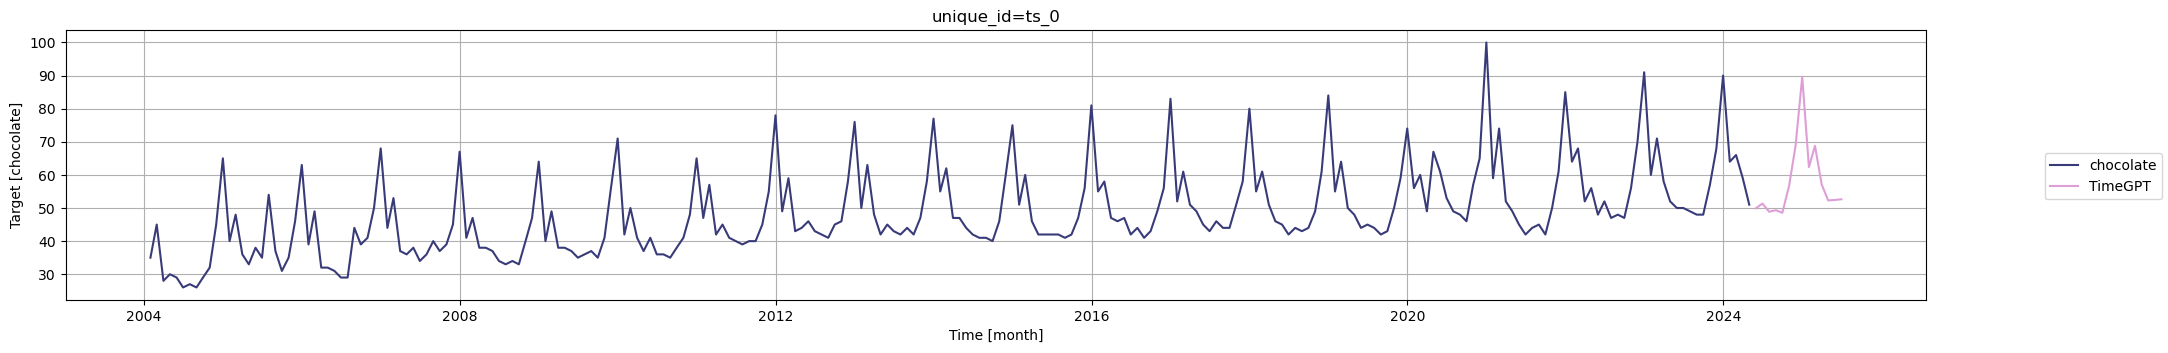

In [ ]:
nixtla_client.plot(
    df, 
    fcst_df, 
    time_col='month',
    target_col='chocolate',
)

We can then plot the weights of each holiday to see which are more important in forecasing the interest in chocolate.

<Axes: ylabel='features'>

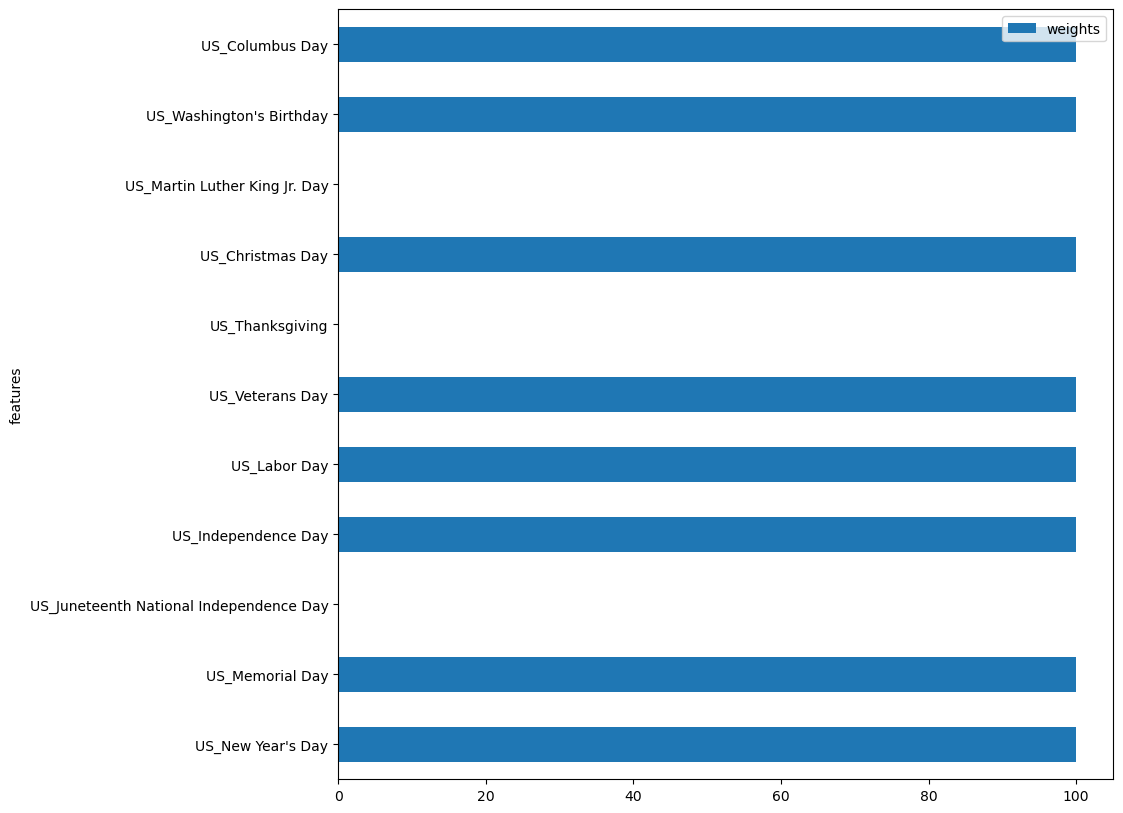

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights', figsize=(10, 10))


Here's a breakdown of how the `date_features` parameter works:<br>

- **`date_features` (bool or list of str or callable)**: This parameter specifies which date attributes to consider.
    - If set to `True`, the model will automatically add the most common date features related to the frequency of the given dataframe (`df`). For a daily frequency, this could include features like day of the week, month, and year.
    - If provided a list of strings, it will consider those specific date attributes. For example, `date_features=['weekday', 'month']` will only add the day of the week and month as features.
    - If provided a callable, it should be a function that takes dates as input and returns the desired feature. This gives flexibility in computing custom date features.

- **`date_features_to_one_hot` (bool or list of str)**:<br> 

After determining the date features, one might want to one-hot encode them, especially if they are categorical in nature (like weekdays). One-hot encoding transforms these categorical features into a binary matrix, making them more suitable for many machine learning algorithms.
    - If `date_features=True`, then by default, all computed date features will be one-hot encoded.
    - If provided a list of strings, only those specific date features will be one-hot encoded.

By leveraging the `date_features` and `date_features_to_one_hot` parameters, one can efficiently incorporate the temporal effects of date attributes into their forecasting model, potentially enhancing its accuracy and interpretability.